In [1]:
from numpy.fft import *
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
import gc
from tensorflow.keras.datasets import mnist, fashion_mnist

## 利用PGD嵌入資訊

In [2]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_test = x_test[:1000]
del(x_train)
del(y_train)
del(y_test)
gc.collect()

num_classes = 10
image_shape = (28, 28, 1)
x_test = x_test.reshape((-1,) + image_shape)


iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍

#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new  = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new , x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

In [3]:
BIT_COUNT = 16

list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [4]:
decoder = load_model('models/decoder_one_hot_4_bit_mnist_binary_crossentropy.h5')
x_test_adv = [x_test.copy() for i in range(BIT_COUNT+1)]
for epoch in range(20):
    print("epoch:",epoch+1)
    for i in range(1, BIT_COUNT+1):
        x_test_adv[i] = pgd_attack_to_target(x_test_adv[i], [user_code[i]] * len(x_test),
                                             tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon, alpha,
                                             iterations)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20


## 低通濾波

In [5]:
def f(img):
    if len(img.shape) == 3:
        img = np.squeeze(img,axis=2)
    img_fftshift = fftshift(fft2(img[:]))
    return exposure.rescale_intensity(np.log(1+abs(img_fftshift)), out_range=(0.0, 1.0))

def lowpass_filter(img,r=15,reverse=False):
    if len(img.shape) == 3:
        img = np.squeeze(img,axis=2)
    img_fftshift = fftshift(fft2(img))
    #畫圈
    ar = np.arange(-14,14)
    x,y = np.meshgrid(ar,ar)
    z= np.sqrt(x**2+y**2)
    f= (z < r)*1
    img_fftshift = img_fftshift*f
    if reverse:
        return np.abs(ifft2(img_fftshift)),exposure.rescale_intensity(np.log(1+abs(img_fftshift)), out_range=(0.0, 1.0))
    return exposure.rescale_intensity(np.log(1+abs(img_fftshift)), out_range=(0.0, 1.0))#限制圖片值在0~1

def lowpass_iterarion(ith_x_test_adv,radius):
    lowpass_x_test = np.squeeze(x_test.copy(),axis=3)
    for i in range(x_test.shape[0]):
        lowpass_x_test[i],_ = lowpass_filter(ith_x_test_adv[i],radius,reverse=True)
    return np.expand_dims(lowpass_x_test,axis=3)

In [6]:
radius = np.linspace(20,1,50)
low_acc = []
for i in range(len(radius)):
    print("{}:".format(i))
    low_tmp_acc = []
    for j in range(BIT_COUNT+1):
        _,acc = decoder.evaluate(lowpass_iterarion(x_test_adv[j],radius[i]), np.array([user_code[j]] * len(x_test)))
        low_tmp_acc.append(acc)
        del(acc)
        gc.collect()
    low_acc.append(np.mean(low_tmp_acc))
    del(low_tmp_acc)
    gc.collect()

0:
32/32 [==============================] - 0s 10ms/step - loss: 2.3503e-09 - categorical_accuracy: 1.0000
1:
32/32 [==============================] - 0s 5ms/step - loss: 0.0101 - categorical_accuracy: 0.9820
2:
32/32 [==============================] - 0s 4ms/step - loss: 0.0101 - categorical_accuracy: 0.9820
3:
32/32 [==============================] - 0s 6ms/step - loss: 0.0233 - categorical_accuracy: 0.9710
4:
32/32 [==============================] - 0s 3ms/step - loss: 0.0233 - categorical_accuracy: 0.9710
5:
32/32 [==============================] - 0s 5ms/step - loss: 0.0402 - categorical_accuracy: 0.9380
6:
32/32 [==============================] - 0s 8ms/step - loss: 0.0796 - categorical_accuracy: 0.8970
7:
32/32 [==============================] - 0s 4ms/step - loss: 0.0796 - categorical_accuracy: 0.8970
8:
32/32 [==============================] - 0s 5ms/step - loss: 0.1594 - categorical_accuracy: 0.8040
9:
32/32 [==============================] - 0s 5ms/step - loss: 0.3085 - cate

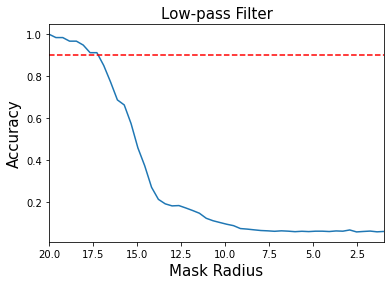

In [8]:
plt.plot(radius,low_acc)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0.9,color='r',linestyle='--')
plt.xlim(max(radius),min(radius))
plt.xlabel("Mask Radius",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.title("Low-pass Filter",fontsize=15)
plt.savefig("lowpass_filter_acc.png")
plt.show()